In [52]:
## Started overall formatting here. We may want to separate functions into different files so it is easier to work on

### Imports
import numpy as np
import matplotlib.pyplot as plt
from numba import njit  
import sys
from numpy.polynomial.legendre import leggauss
from scipy.sparse import diags
from scipy.sparse.linalg import bicgstab
from numpy.linalg import norm
from matplotlib import cm
from matplotlib.colors import Normalize


In [53]:

### Arguments
N = 128 # Number of divisions in the radial direction
G = 9.81  # Acceleration due to gravity (m/s^2)
NU = 1    # Kinematic viscosity (m^2/s)
DT = 0.00001  # Time step (s)
SIMULATION_TIME = 100  # Total time for simulation (s)


In [54]:
@njit
def trapezoidal_integral(r, u):
    integral = 0.0
    for i in range(1, len(u)):
        area = np.pi * (r[i]**2 - r[i-1]**2)
        average_height = (u[i] + u[i-1]) / 2
        integral += area * average_height
    return integral

@njit
def update_profile(delta, b, xi):
    delta_new = np.zeros_like(delta)
    for i in range(1, N-1):
        r_factor = delta[i]**3 / b**2
        dxi = xi[i+1] - xi[i]
        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2
        convective = 3 * delta[i]**2 * (delta[i+1] - delta[i-1]) / (2 * dxi)
        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    return delta_new

def main_simulation():
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    b = 1.0
    V0 = trapezoidal_integral(b * xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []

    for time in np.arange(0, SIMULATION_TIME, DT):
        delta_new = update_profile(delta, b, xi)
        V_new = trapezoidal_integral(b * xi, delta_new)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time)
        deltas.append(delta.copy())

    return xi, times, bs, volumes, deltas


In [55]:
xi, times, bs, volumes, deltas = main_simulation()

In [56]:
### Gauss-Legendre integration
from numpy.polynomial.legendre import leggauss  # Importing Gauss-Legendre quadrature

# Precompute Gauss-Legendre nodes and weights for an n-point quadrature
def precompute_gauss_legendre(n):
    """Precompute Gauss-Legendre nodes and weights."""
    nodes, weights = leggauss(n)
    return nodes, weights

@njit
def gauss_legendre_integral(xi, delta, nodes, weights):
    """Calculate the integral using precomputed Gauss-Legendre nodes and weights."""
    a, b = xi[0], xi[-1]  # Integration limits
    x_mapped = 0.5 * (nodes + 1) * (b - a) + a
    w_mapped = weights * 0.5 * (b - a)
    delta_interp = np.interp(x_mapped, xi, delta)
    integral = np.sum(w_mapped * delta_interp)
    return integral

@njit
def update_profile(delta, b, xi):
    """Update the drop profile for one time step."""
    delta_new = np.zeros_like(delta)
    for i in range(1, N-1):
        r_factor = delta[i]**3 / b**2
        dxi = xi[i+1] - xi[i]
        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2
        convective = 3 * delta[i]**2 * (delta[i+1] - delta[i-1]) / (2 * dxi)
        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    return delta_new

def main_simulation():
    """Run the main simulation."""
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    b = 1.0
    nodes, weights = precompute_gauss_legendre(50)  # Using 50 points for Gauss-Legendre Quadrature
    V0 = gauss_legendre_integral(xi, delta, nodes, weights)

    volumes, bs, times, deltas = [], [], [], []
    for time in np.arange(0, SIMULATION_TIME, DT):
        delta_new = update_profile(delta, b, xi)
        V_new = gauss_legendre_integral(xi, delta_new, nodes, weights)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time)
        deltas.append(delta.copy())

    return xi, times, bs, volumes, deltas




In [57]:
#xi, times, bs, volumes, deltas = main_simulation()

In [58]:
### SImpsons 
'''
@njit
def simpsons_rule(xi, delta):
    """Calculate the integral of `delta` over `xi` using Simpson's rule."""
    h = (xi[-1] - xi[0]) / (len(xi) - 1)
    integral = delta[0] + delta[-1] + 4 * np.sum(delta[1:-1:2]) + 2 * np.sum(delta[2:-2:2])
    integral *= h / 3
    return integral

@njit
def update_profile(delta, b, xi):
    delta_new = np.zeros_like(delta)
    for i in range(1, N-1):
        r_factor = delta[i]**3 / b**2
        dxi = xi[i+1] - xi[i]
        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2
        convective = 3 * delta[i]**2 * (delta[i+1] - delta[i-1]) / (2 * dxi)
        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    return delta_new

def main_simulation():
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    b = 1.0
    V0 = simpsons_rule(xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []

    for time in np.arange(0, SIMULATION_TIME, DT):
        delta_new = update_profile(delta, b, xi)
        V_new = simpsons_rule(xi, delta_new)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time)
        deltas.append(delta.copy())

    return xi, times, bs, volumes, deltas
    '''

'\n@njit\ndef simpsons_rule(xi, delta):\n    """Calculate the integral of `delta` over `xi` using Simpson\'s rule."""\n    h = (xi[-1] - xi[0]) / (len(xi) - 1)\n    integral = delta[0] + delta[-1] + 4 * np.sum(delta[1:-1:2]) + 2 * np.sum(delta[2:-2:2])\n    integral *= h / 3\n    return integral\n\n@njit\ndef update_profile(delta, b, xi):\n    delta_new = np.zeros_like(delta)\n    for i in range(1, N-1):\n        r_factor = delta[i]**3 / b**2\n        dxi = xi[i+1] - xi[i]\n        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2\n        convective = 3 * delta[i]**2 * (delta[i+1] - delta[i-1]) / (2 * dxi)\n        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)\n    delta_new[0] = delta_new[1]\n    delta_new[-1] = 0\n    return delta_new\n\ndef main_simulation():\n    xi = np.linspace(0, 1, N)\n    delta = np.sqrt(1 - xi**2)\n    b = 1.0\n    V0 = simpsons_rule(xi, delta)\n\n    volumes = []\n    bs = []\n    times = []\n    deltas = []

In [59]:
#xi, times, bs, volumes, deltas = main_simulation()

/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_93843/2593289099.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Time (s)')


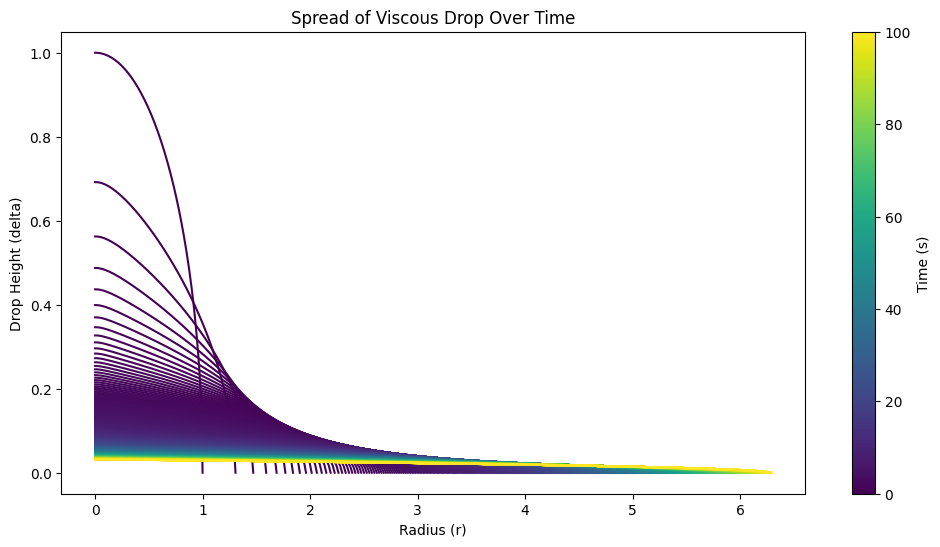

In [60]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Configuración inicial para la coloración
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=SIMULATION_TIME)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(12, 6))

step = int(len(times) / 1000) 

for i in range(0, len(deltas), step):
    plt.plot(xi * bs[i], deltas[i], color=cmap(norm(times[i])))

plt.colorbar(sm, label='Time (s)')
plt.xlabel('Radius (r)')
plt.ylabel('Drop Height (delta)')
plt.title('Spread of Viscous Drop Over Time')
plt.show()



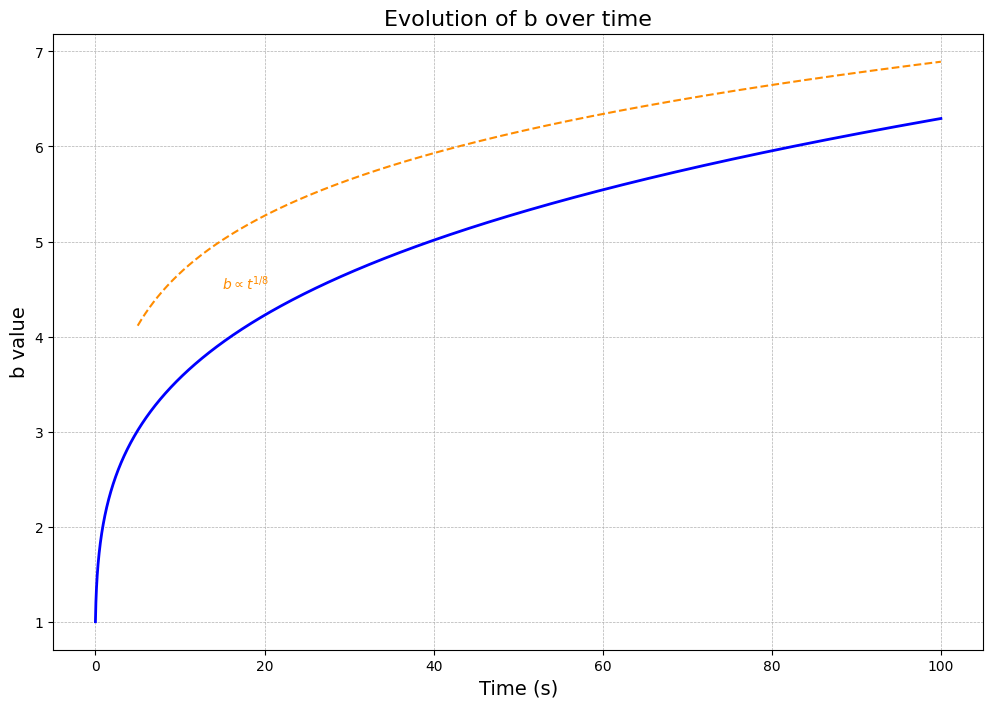

In [61]:
times = np.array(times)  
bs = np.array(bs)

start_index = np.where(times > 5)[0][0]  
plt.figure(figsize=(12, 8))

plt.plot(times[start_index:], 5 * times[start_index:]**(1/8) - 2, label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
plt.text(15,4.5, r'$b \propto t^{1/8}$',color = 'darkorange' )

plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.legend(fontsize=12)

plt.show()



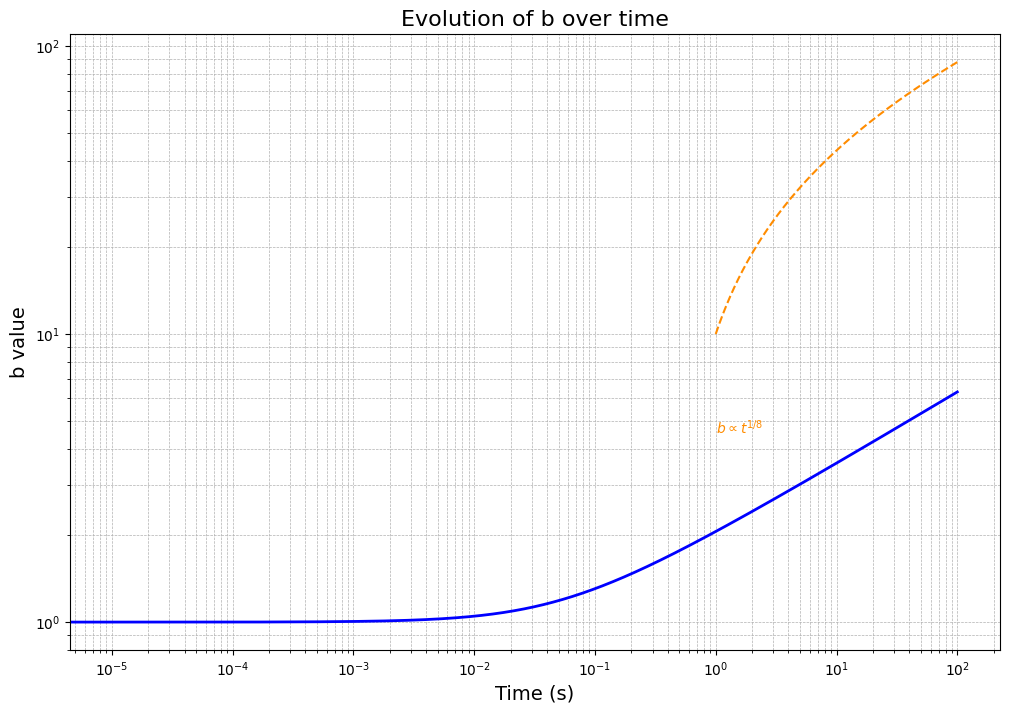

In [62]:
times = np.array(times)  
bs = np.array(bs)

start_index = np.where(times > 1)[0][0]  
plt.figure(figsize=(12, 8))

plt.plot(times[start_index:],  100*times[start_index:]**(1/8) -90 , label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
plt.text(1,4.5, r'$b \propto t^{1/8}$',color = 'darkorange' )

plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [63]:
volumes

[2.0929452764673715,
 2.0928701294577956,
 2.0928451471191747,
 2.0928368873767544,
 2.092834202117088,
 2.092833375206759,
 2.0928331677566363,
 2.092833166804018,
 2.092833234637845,
 2.092833325366014,
 2.092833423662903,
 2.0928335244303375,
 2.092833625951115,
 2.092833727661518,
 2.0928338293609774,
 2.0928339309901203,
 2.0928340325194403,
 2.0928341339457526,
 2.092834235260123,
 2.092834336465631,
 2.0928344375566508,
 2.0928345385369282,
 2.092834639401895,
 2.0928347401553364,
 2.0928348407932784,
 2.0928349413194667,
 2.092835041730332,
 2.092835142029591,
 2.0928352422139485,
 2.0928353422870916,
 2.0928354422459274,
 2.092835542094128,
 2.0928356418287337,
 2.0928357414534107,
 2.0928358409652823,
 2.092835940368028,
 2.0928360396588164,
 2.0928361388413426,
 2.0928362379127976,
 2.0928363368769056,
 2.0928364357308458,
 2.092836534478393,
 2.09283663311668,
 2.092836731649548,
 2.0928368300740763,
 2.0928369283941697,
 2.0928370266068375,
 2.0928371247160653,
 2.09283722

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for scaling
C = 1  # Adjust as per the problem's requirement for correct scaling
G = 9.81  # Gravitational constant
 
xi = np.linspace(0, 1, N)
delta = np.sqrt(1 - xi**2)
b = 1.0
V0 = trapezoidal_integral(b * xi, delta)

def plot_similarity_solution(xi, times, bs, deltas, V0):
    plt.figure(figsize=(10, 6))
    cmap = cm.viridis  # Choose a colormap
    norm = Normalize(vmin=min(times), vmax=max(times))  # Normalize times for color mapping

    # Create a ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Calculate how many points to skip to reduce the plot to about 100 points
    step = max(1, len(times) // 100)

    # Plot each profile with color mapped to time
    for i in range(0, len(times), step):
        time = times[i]
        if time >= 0:  # Avoid division by zero and initial time
            nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
            f = deltas[i] / (3 * V0 * (1 / (16 * np.pi * C * G * time)))**(1/4)
            plt.plot(nu, f, color=cmap(norm(time)))

    plt.colorbar(sm, label='Time (s)')
    plt.xlabel(r'$\nu$')
    plt.ylabel(r'$f(\nu)$')
    plt.title('Self-similar Solution Over Time')
    plt.xlim([0,4])  
    plt.grid(True)
    plt.show()



/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_93843/1607049271.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_93843/1607049271.py:29: RuntimeWarning: invalid value encountered in multiply
  nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_93843/1607049271.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  f = deltas[i] / (3 * V0 * (1 / (16 * np.pi * C * G * time)))**(1/4)
/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_93843/1607049271.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.

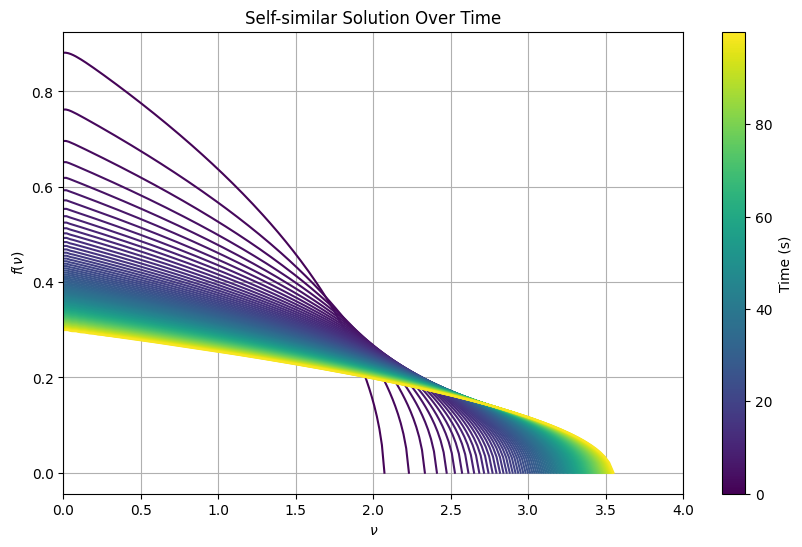

In [65]:
#xi, times, bs, volumes, deltas = main_simulation()
plot_similarity_solution(xi, times, bs, deltas, V0)

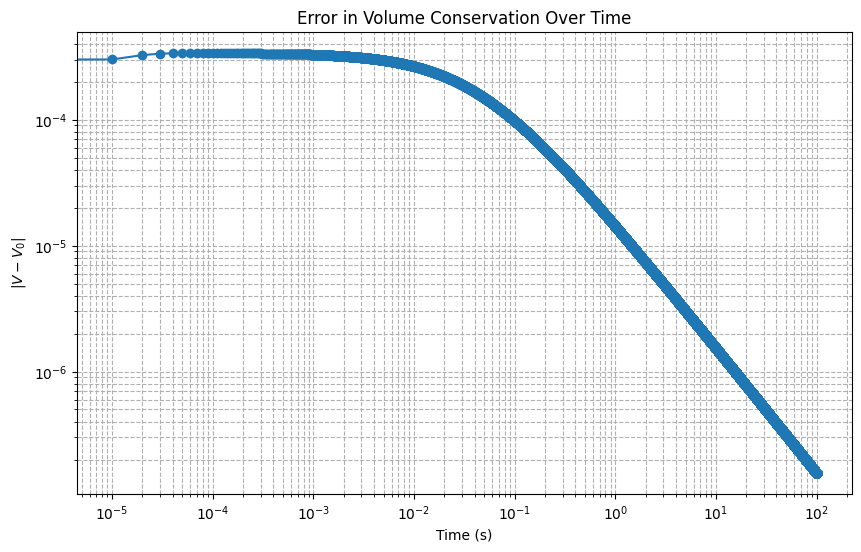

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate absolute difference from the initial volume
volume_errors = np.abs(np.array(volumes) - V0)

# Plotting the error over time on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.loglog(times, volume_errors, marker='o', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel(r'$|V-V_0|$')
plt.title('Error in Volume Conservation Over Time')
plt.grid(True, which="both", ls="--")
plt.show()
